In [3]:
import os
import numpy as np
import pandas as pd
import pickle
from datetime import timedelta, datetime
import matplotlib.pyplot as plt


In [2]:
from joblib import load

model_path = '/content/drive/MyDrive/fraud_detection_checkpoints/epoch_checkpoints/rf_epoch_6.pkl'
model = load(model_path)

In [3]:
dataset_path = '/content/drive/MyDrive/AIML Dataset.csv'  # adjust path
df = pd.read_csv(dataset_path)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
drive_dir = "/content/drive/MyDrive/fraud_detection_checkpoints/dailyData"
os.makedirs(drive_dir, exist_ok=True)

def split_dataset(df, days=30, save_dir=drive_dir):
    chunk_size = len(df) // days
    chunks = []
    for i in range(days):
        start_idx = i * chunk_size
        end_idx = (i + 1) * chunk_size if i < days - 1 else len(df)
        chunk = df.iloc[start_idx:end_idx].copy()
        raw_path = os.path.join(save_dir, f"raw_day_{i+1}.parquet")
        chunk.to_parquet(raw_path)
        chunks.append(raw_path)
        print(f"✅ Saved raw chunk {i+1}/{days} -> {raw_path} ({len(chunk)} rows)")
    return chunks

raw_paths = split_dataset(df, days=30)

✅ Saved raw chunk 1/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/dailyData/raw_day_1.parquet (212087 rows)
✅ Saved raw chunk 2/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/dailyData/raw_day_2.parquet (212087 rows)
✅ Saved raw chunk 3/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/dailyData/raw_day_3.parquet (212087 rows)
✅ Saved raw chunk 4/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/dailyData/raw_day_4.parquet (212087 rows)
✅ Saved raw chunk 5/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/dailyData/raw_day_5.parquet (212087 rows)
✅ Saved raw chunk 6/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/dailyData/raw_day_6.parquet (212087 rows)
✅ Saved raw chunk 7/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/dailyData/raw_day_7.parquet (212087 rows)
✅ Saved raw chunk 8/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/dailyData/raw_day_8.parquet (212087 rows)
✅ Saved raw chunk 9/30 -> /content/drive/MyDrive

In [5]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta

time_series_dir = '/content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData'
os.makedirs(time_series_dir, exist_ok=True)

def generate_timeseries_for_chunk(raw_path, day_idx, days=30, save_dir=time_series_dir):
    df = pd.read_parquet(raw_path)
    start_date = datetime.now() - timedelta(days=days)
    current_date = start_date + timedelta(days=day_idx)

    timestamps = []
    for _, row in df.iterrows():
        if row['isFraud']:
            # Fraud: Bimodal peaks at 14:00 and 22:00
            peak_hour = np.random.choice([14, 22])
            hour = np.random.normal(loc=peak_hour, scale=3)
        else:
            # Normal: Unimodal peak at 14:00 (2 PM)
            hour = np.random.normal(loc=14, scale=3)

        # Clip to valid 0–23 range and round to nearest minute
        hour = np.clip(hour, 0, 23)
        minute = np.random.randint(0, 60)
        second = np.random.randint(0, 60)

        ts = current_date + timedelta(hours=int(hour), minutes=minute, seconds=second)
        timestamps.append(ts)

    df['timestamp'] = timestamps

    ts_path = os.path.join(save_dir, f"time_series_day_{day_idx+1}.parquet")
    df.to_parquet(ts_path)
    print(f"✅ Generated timeseries for day {day_idx+1}/{days} -> {ts_path}")
    return ts_path

# --- Process each chunk safely (low RAM) ---
ts_paths = []
for i, path in enumerate(raw_paths):
    ts_paths.append(generate_timeseries_for_chunk(path, i))

print("\n🎯 All 30 days processed and saved safely to Drive!")


✅ Generated timeseries for day 1/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_1.parquet
✅ Generated timeseries for day 2/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_2.parquet
✅ Generated timeseries for day 3/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_3.parquet
✅ Generated timeseries for day 4/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_4.parquet
✅ Generated timeseries for day 5/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_5.parquet
✅ Generated timeseries for day 6/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_6.parquet
✅ Generated timeseries for day 7/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_7.parquet
✅ Generated timeseries for day 8/30 -> /content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/ti

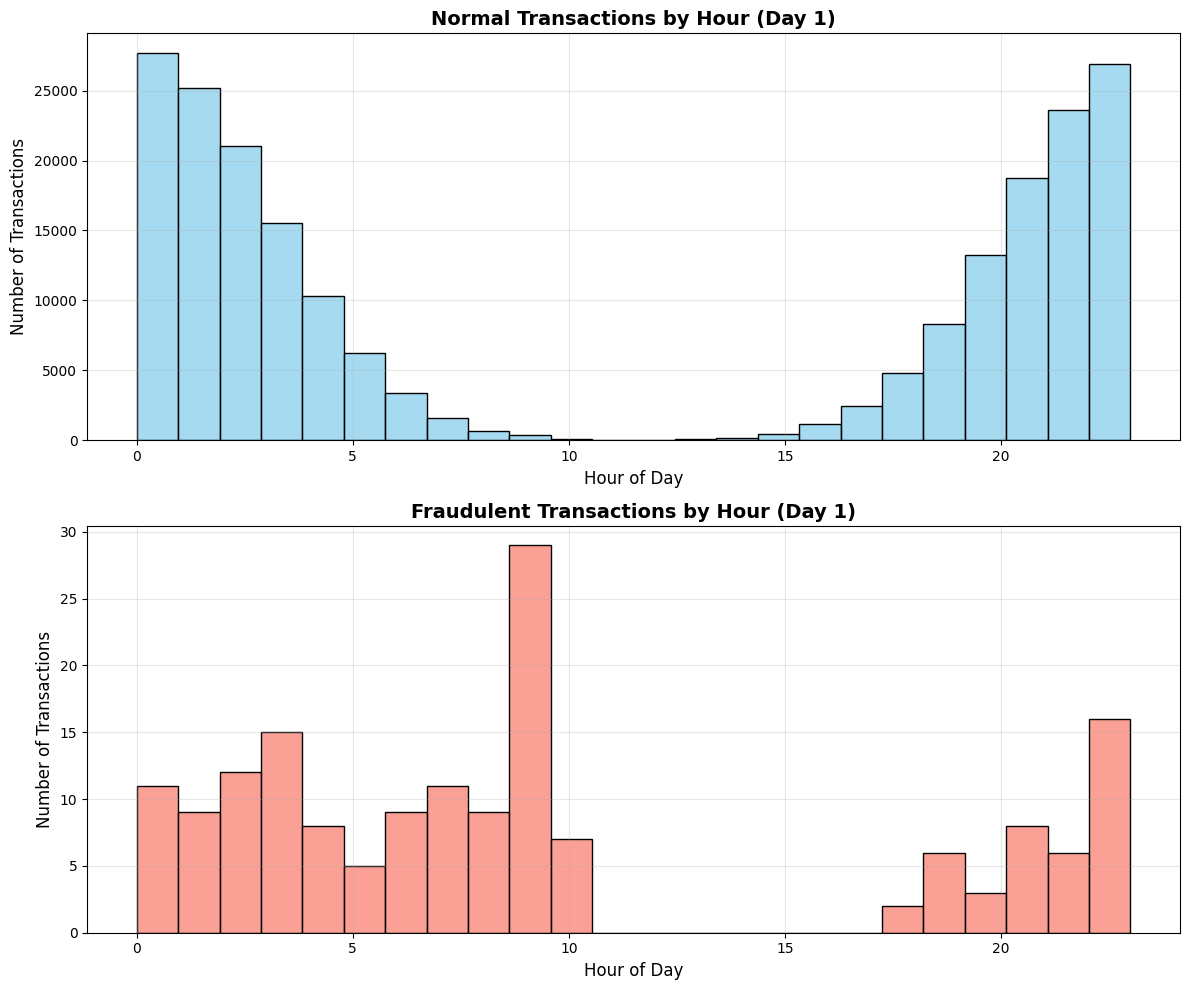

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to one day's file
day_path = "/content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_3.parquet"

df_day = pd.read_parquet(day_path)
df_day['hour'] = df_day['timestamp'].dt.hour

# Split into normal and fraud
df_normal = df_day[df_day['isFraud'] == 0]
df_fraud = df_day[df_day['isFraud'] == 1]

plt.figure(figsize=(12, 10))

# ---- Plot 1: Normal Transactions ----
plt.subplot(2, 1, 1)
sns.histplot(df_normal['hour'], bins=24, color='skyblue')
plt.title("Normal Transactions by Hour (Day 1)", fontsize=14, weight='bold')
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.grid(alpha=0.3)

# ---- Plot 2: Fraud Transactions ----
plt.subplot(2, 1, 2)
sns.histplot(df_fraud['hour'], bins=24, color='salmon')
plt.title("Fraudulent Transactions by Hour (Day 1)", fontsize=14, weight='bold')
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Transactions", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [7]:
df_day.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,timestamp,hour
424174,18,PAYMENT,2512.38,C792710404,104883.00,102370.62,M2095800220,0.00,0.00,0,0,2025-09-14 23:20:50.264622,23
424175,18,CASH_OUT,133357.13,C936809408,102370.62,0.00,C1453070531,850883.04,880419.91,0,0,2025-09-15 03:01:59.264622,3
424176,18,CASH_OUT,199498.38,C1779228556,0.00,0.00,C8897912,1730428.44,2031165.57,0,0,2025-09-14 23:33:09.264622,23
424177,18,PAYMENT,6599.91,C990537764,149840.00,143240.09,M498845542,0.00,0.00,0,0,2025-09-14 22:47:32.264622,22
424178,18,CASH_IN,262190.80,C519049090,10302.00,272492.80,C1380720615,2339067.93,2076877.12,0,0,2025-09-15 00:57:09.264622,0


In [9]:
import numpy as np

df_day['orig_balance_change'] = df_day['newbalanceOrig'] - df_day['oldbalanceOrg']
df_day['dest_balance_change'] = df_day['newbalanceDest'] - df_day['oldbalanceDest']

df_day['orig_balance_zero'] = (df_day['oldbalanceOrg'] == 0).astype(int)
df_day['dest_balance_zero'] = (df_day['newbalanceDest'] == 0).astype(int)

df_day['orig_rel_change'] = df_day['orig_balance_change'] / (df_day['oldbalanceOrg'] + 1e-9)
df_day['dest_rel_change'] = df_day['dest_balance_change'] / (df_day['oldbalanceDest'] + 1e-9)

df_day['zero_transfer'] = (df_day['amount'] == 0).astype(int)
df_day['same_account'] = (df_day['nameOrig'] == df_day['nameDest']).astype(int)
df_day['log_amount'] = np.log1p(df_day['amount'])


In [1]:
import joblib
model_path = '/content/drive/MyDrive/fraud_detection_checkpoints/epoch_checkpoints/rf_epoch_19.pkl'
# model = load(model_path)
model = joblib.load("/content/drive/MyDrive/fraud_detection_checkpoints/epoch_checkpoints/rf_epoch_19.pkl")
print(model)


RandomForestClassifier(n_estimators=114, n_jobs=-1, random_state=42)


✅ Model Performance on Day 1
Accuracy: 0.9991
Precision: 0.1515
Recall: 0.0301
F1 Score: 0.0503
AUC: 0.9793


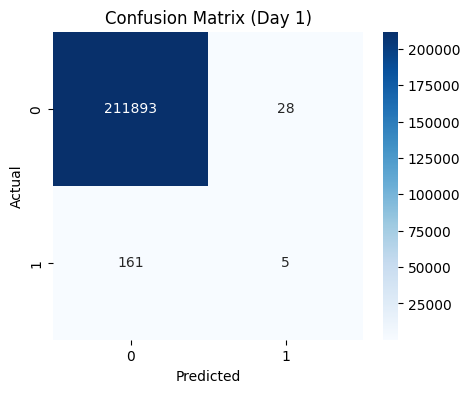

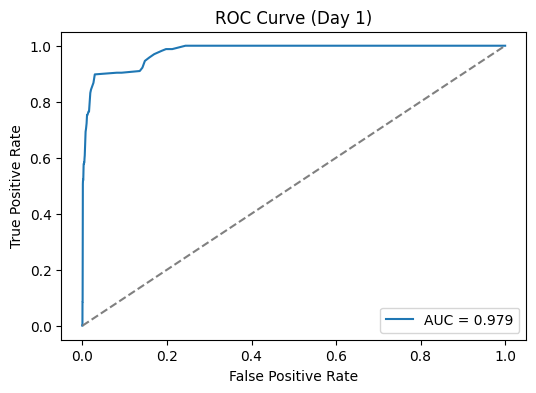

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Metrics
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auc = roc_auc_score(y, y_proba)

print(f"✅ Model Performance on Day 1")
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

# Confusion matrix
cm = confusion_matrix(y, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Day 1)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y, y_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Day 1)")
plt.legend()
plt.show()


In [9]:
day_path = "/content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_3.parquet"

df_day = pd.read_parquet(day_path)
df_day.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,timestamp
424174,18,PAYMENT,2512.38,C792710404,104883.00,102370.62,M2095800220,0.00,0.00,0,0,2025-09-14 23:20:50.264622
424175,18,CASH_OUT,133357.13,C936809408,102370.62,0.00,C1453070531,850883.04,880419.91,0,0,2025-09-15 03:01:59.264622
424176,18,CASH_OUT,199498.38,C1779228556,0.00,0.00,C8897912,1730428.44,2031165.57,0,0,2025-09-14 23:33:09.264622
424177,18,PAYMENT,6599.91,C990537764,149840.00,143240.09,M498845542,0.00,0.00,0,0,2025-09-14 22:47:32.264622
424178,18,CASH_IN,262190.80,C519049090,10302.00,272492.80,C1380720615,2339067.93,2076877.12,0,0,2025-09-15 00:57:09.264622


In [10]:
# 1️⃣ Apply same feature engineering
df_day['orig_balance_change'] = df_day['oldbalanceOrg'] - df_day['newbalanceOrig']
df_day['dest_balance_change'] = df_day['newbalanceDest'] - df_day['oldbalanceDest']
df_day['orig_balance_zero'] = (df_day['oldbalanceOrg'] == 0).astype(int)
df_day['dest_balance_zero'] = (df_day['oldbalanceDest'] == 0).astype(int)
df_day['orig_rel_change'] = df_day['orig_balance_change'] / (df_day['oldbalanceOrg'] + 1e-6)
df_day['dest_rel_change'] = df_day['dest_balance_change'] / (df_day['oldbalanceDest'] + 1e-6)
df_day['zero_transfer'] = ((df_day['amount'] > 0) & (df_day['newbalanceDest'] == 0)).astype(int)
df_day['same_account'] = (df_day['nameOrig'] == df_day['nameDest']).astype(int)
df_day['log_amount'] = np.log1p(df_day['amount'])

# 2️⃣ Select model-relevant features
X_day = df_day[feature_cols].copy()
y_day = df_day['isFraud'].astype(int)

# 3️⃣ Encode 'type' column exactly like before
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_cols = [c for c in feature_cols if c != 'type']
cat_cols = ['type']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

preprocessor_day = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

X_day_enc = preprocessor_day.fit_transform(X_day)
print("✅ Encoded daily data shape:", X_day_enc.shape)


✅ Encoded daily data shape: (212087, 18)


In [17]:
import pandas as pd, numpy as np, joblib, os
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# === CONFIG ===
day_path = "/content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_3.parquet"
rf_ckpt = "/content/drive/MyDrive/fraud_detection_checkpoints/epoch_checkpoints/rf_epoch_50.pkl"

# === 1. Load daily dataset ===
print(f"📂 Loading daily file: {day_path}")
df_day = pd.read_parquet(day_path)
print("Rows:", len(df_day), "| Fraud counts:", df_day['isFraud'].value_counts().to_dict())

# === 2. Feature engineering (exactly same as training) ===
print("🧮 Applying feature engineering...")
df_day['orig_balance_change'] = df_day['oldbalanceOrg'] - df_day['newbalanceOrig']
df_day['dest_balance_change'] = df_day['newbalanceDest'] - df_day['oldbalanceDest']
df_day['orig_balance_zero'] = (df_day['oldbalanceOrg'] == 0).astype(int)
df_day['dest_balance_zero'] = (df_day['oldbalanceDest'] == 0).astype(int)
df_day['orig_rel_change'] = df_day['orig_balance_change'] / (df_day['oldbalanceOrg'] + 1e-6)
df_day['dest_rel_change'] = df_day['dest_balance_change'] / (df_day['oldbalanceDest'] + 1e-6)
df_day['zero_transfer'] = ((df_day['amount'] > 0) & (df_day['newbalanceDest'] == 0)).astype(int)
df_day['same_account'] = (df_day['nameOrig'] == df_day['nameDest']).astype(int)
df_day['log_amount'] = np.log1p(df_day['amount'])

feature_cols = [
    'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
    'isFlaggedFraud','orig_balance_change','dest_balance_change',
    'orig_balance_zero','dest_balance_zero','orig_rel_change','dest_rel_change',
    'zero_transfer','same_account','log_amount','type'
]

X_day = df_day[feature_cols].copy()
y_day = df_day['isFraud'].astype(int)

# === 3. Apply same preprocessing ===
num_cols = [c for c in feature_cols if c != 'type']
cat_cols = ['type']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

X_day_enc = preprocessor.fit_transform(X_day)
print("✅ Encoded daily data shape:", X_day_enc.shape)

# === 4. Load model ===
print(f"\n🧠 Loading RandomForest model from {rf_ckpt}")
rf = joblib.load(rf_ckpt)
print("Model expects:", rf.n_features_in_, " | Test data:", X_day_enc.shape[1])

# === 5. Align columns if mismatch ===
if X_day_enc.shape[1] != rf.n_features_in_:
    print("⚠️ Feature mismatch detected! Attempting auto-align...")
    # pad or trim
    n_diff = rf.n_features_in_ - X_day_enc.shape[1]
    if n_diff > 0:
        X_day_enc = np.hstack([X_day_enc, np.zeros((X_day_enc.shape[0], n_diff))])
    else:
        X_day_enc = X_day_enc[:, :rf.n_features_in_]
    print("✅ Adjusted features:", X_day_enc.shape[1])

# === 6. Run inference ===
print("\n🚀 Running predictions...")
y_pred = rf.predict(X_day_enc)
y_proba = rf.predict_proba(X_day_enc)[:, 1]

# === 7. Metrics ===
print("\n🔹 Confusion Matrix:")
print(confusion_matrix(y_day, y_pred))
print("\n🔹 Classification Report:")
print(classification_report(y_day, y_pred, digits=4))
print("ROC-AUC:", round(roc_auc_score(y_day, y_proba), 6))
print("PR-AUC :", round(average_precision_score(y_day, y_proba), 6))


📂 Loading daily file: /content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_3.parquet
Rows: 212087 | Fraud counts: {0: 211921, 1: 166}
🧮 Applying feature engineering...
✅ Encoded daily data shape: (212087, 18)

🧠 Loading RandomForest model from /content/drive/MyDrive/fraud_detection_checkpoints/epoch_checkpoints/rf_epoch_50.pkl
Model expects: 18  | Test data: 18

🚀 Running predictions...

🔹 Confusion Matrix:
[[206066   5855]
 [    14    152]]

🔹 Classification Report:
              precision    recall  f1-score   support

           0     0.9999    0.9724    0.9860    211921
           1     0.0253    0.9157    0.0492       166

    accuracy                         0.9723    212087
   macro avg     0.5126    0.9440    0.5176    212087
weighted avg     0.9992    0.9723    0.9852    212087

ROC-AUC: 0.989313
PR-AUC : 0.29464


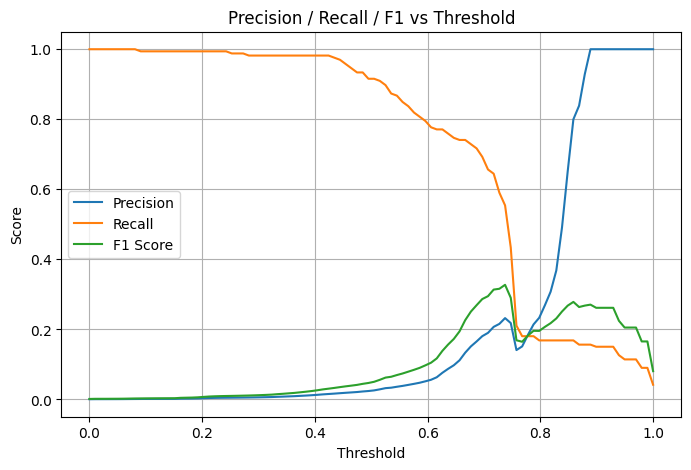

🔥 Best threshold: 0.737
Precision: 0.2323, Recall: 0.5542, F1: 0.3274


In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have:
# y_day (true labels)
# y_proba (RF predicted probabilities for fraud class)

thresholds = np.linspace(0, 1, 100)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    preds = (y_proba >= t).astype(int)
    precisions.append(precision_score(y_day, preds))
    recalls.append(recall_score(y_day, preds))
    f1s.append(f1_score(y_day, preds))

# Plot precision-recall tradeoff
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision / Recall / F1 vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find best threshold (maximize F1)
best_idx = np.argmax(f1s)
best_threshold = thresholds[best_idx]
print(f"🔥 Best threshold: {best_threshold:.3f}")
print(f"Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}, F1: {f1s[best_idx]:.4f}")


In [20]:
y_pred_opt = (y_proba >= best_threshold).astype(int)
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_day, y_pred_opt))
print(classification_report(y_day, y_pred_opt, digits=4))


[[211617    304]
 [    74     92]]
              precision    recall  f1-score   support

           0     0.9997    0.9986    0.9991    211921
           1     0.2323    0.5542    0.3274       166

    accuracy                         0.9982    212087
   macro avg     0.6160    0.7764    0.6633    212087
weighted avg     0.9990    0.9982    0.9986    212087



In [22]:
# y_proba = predicted probabilities from Random Forest
y_action = []

for p in y_proba:
    if p >= 0.737:
        y_action.append('STOP')
    elif p >= 0.5:
        y_action.append('MANUAL_REVIEW')
    else:
        y_action.append('ALLOW')

# Convert to DataFrame if needed
import pandas as pd
df = pd.DataFrame({'probability': y_proba, 'action': y_action})

In [24]:
df

,probability,action
0,0.060000,ALLOW
1,0.453333,ALLOW
2,0.080000,ALLOW
3,0.060000,ALLOW
4,0.000000,ALLOW
...,...,...
212082,0.203333,ALLOW
212083,0.226667,ALLOW
212084,0.113333,ALLOW
212085,0.156667,ALLOW


In [25]:
import pandas as pd
import numpy as np
import joblib, os, glob
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# === CONFIG ===
data_folder = "/content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/"
rf_ckpt = "/content/drive/MyDrive/fraud_detection_checkpoints/epoch_checkpoints/rf_epoch_50.pkl"
save_results_folder = "/content/drive/MyDrive/fraud_detection_checkpoints/results/"
os.makedirs(save_results_folder, exist_ok=True)

# Thresholds for business actions
stop_threshold = 0.737
manual_threshold = 0.5

# === 1. Load RF model ===
print(f"🧠 Loading RandomForest model from {rf_ckpt}")
rf = joblib.load(rf_ckpt)

# === 2. Preprocessing setup ===
feature_cols = [
    'oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest',
    'isFlaggedFraud','orig_balance_change','dest_balance_change',
    'orig_balance_zero','dest_balance_zero','orig_rel_change','dest_rel_change',
    'zero_transfer','same_account','log_amount','type'
]
num_cols = [c for c in feature_cols if c != 'type']
cat_cols = ['type']

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# === 3. Loop over all daily files ===
daily_files = sorted(glob.glob(os.path.join(data_folder, "*.parquet")))

all_metrics = []

for day_file in daily_files:
    print(f"\n📂 Processing {day_file}")
    df_day = pd.read_parquet(day_file)
    print("Rows:", len(df_day), "| Fraud counts:", df_day['isFraud'].value_counts().to_dict())

    # Feature engineering
    df_day['orig_balance_change'] = df_day['oldbalanceOrg'] - df_day['newbalanceOrig']
    df_day['dest_balance_change'] = df_day['newbalanceDest'] - df_day['oldbalanceDest']
    df_day['orig_balance_zero'] = (df_day['oldbalanceOrg'] == 0).astype(int)
    df_day['dest_balance_zero'] = (df_day['oldbalanceDest'] == 0).astype(int)
    df_day['orig_rel_change'] = df_day['orig_balance_change'] / (df_day['oldbalanceOrg'] + 1e-6)
    df_day['dest_rel_change'] = df_day['dest_balance_change'] / (df_day['oldbalanceDest'] + 1e-6)
    df_day['zero_transfer'] = ((df_day['amount'] > 0) & (df_day['newbalanceDest'] == 0)).astype(int)
    df_day['same_account'] = (df_day['nameOrig'] == df_day['nameDest']).astype(int)
    df_day['log_amount'] = np.log1p(df_day['amount'])

    X_day = df_day[feature_cols].copy()
    y_day = df_day['isFraud'].astype(int)

    # Preprocess
    X_day_enc = preprocessor.fit_transform(X_day)

    # Align features if mismatch
    if X_day_enc.shape[1] != rf.n_features_in_:
        n_diff = rf.n_features_in_ - X_day_enc.shape[1]
        if n_diff > 0:
            X_day_enc = np.hstack([X_day_enc, np.zeros((X_day_enc.shape[0], n_diff))])
        else:
            X_day_enc = X_day_enc[:, :rf.n_features_in_]

    # Predict
    y_proba = rf.predict_proba(X_day_enc)[:,1]

    # Apply thresholds for actions
    y_action = []
    for p in y_proba:
        if p >= stop_threshold:
            y_action.append('STOP')
        elif p >= manual_threshold:
            y_action.append('MANUAL_REVIEW')
        else:
            y_action.append('ALLOW')

    df_results = df_day.copy()
    df_results['probability'] = y_proba
    df_results['action'] = y_action
    save_path = os.path.join(save_results_folder, os.path.basename(day_file).replace(".parquet","_results.csv"))
    df_results.to_csv(save_path, index=False)
    print(f"✅ Saved results to {save_path}")

    # Metrics
    best_threshold = manual_threshold  # use manual_threshold as F1-optimal proxy if needed
    y_pred_opt = (y_proba >= best_threshold).astype(int)

    cm = confusion_matrix(y_day, y_pred_opt)
    cr = classification_report(y_day, y_pred_opt, digits=4, output_dict=True)
    roc = roc_auc_score(y_day, y_proba)
    pr = average_precision_score(y_day, y_proba)

    print("\nConfusion Matrix:")
    print(cm)
    print("\nClassification Report:")
    print(classification_report(y_day, y_pred_opt, digits=4))
    print(f"ROC-AUC: {roc:.6f} | PR-AUC: {pr:.6f}")

    # Save metrics
    all_metrics.append({
        'day_file': os.path.basename(day_file),
        'roc_auc': roc,
        'pr_auc': pr,
        'precision': cr['1']['precision'],
        'recall': cr['1']['recall'],
        'f1': cr['1']['f1-score'],
        'total_frauds': int(y_day.sum()),
        'stop_actions': y_action.count('STOP'),
        'manual_actions': y_action.count('MANUAL_REVIEW'),
        'allow_actions': y_action.count('ALLOW')
    })

# Save overall metrics
metrics_df = pd.DataFrame(all_metrics)
metrics_df.to_csv(os.path.join(save_results_folder, "summary_metrics.csv"), index=False)
print("\n🔥 Summary metrics saved.")


🧠 Loading RandomForest model from /content/drive/MyDrive/fraud_detection_checkpoints/epoch_checkpoints/rf_epoch_50.pkl

📂 Processing /content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_1.parquet
Rows: 212087 | Fraud counts: {0: 211935, 1: 152}
✅ Saved results to /content/drive/MyDrive/fraud_detection_checkpoints/results/time_series_day_1_results.csv

Confusion Matrix:
[[209492   2443]
 [    40    112]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9885    0.9941    211935
           1     0.0438    0.7368    0.0827       152

    accuracy                         0.9883    212087
   macro avg     0.5218    0.8627    0.5384    212087
weighted avg     0.9991    0.9883    0.9935    212087

ROC-AUC: 0.981287 | PR-AUC: 0.133728

📂 Processing /content/drive/MyDrive/fraud_detection_checkpoints/TSdailyData/time_series_day_10.parquet
Rows: 212087 | Fraud counts: {0: 211906, 1: 181}
✅ Saved results to /conten

In [26]:
import pandas as pd

metrics_path = "/content/drive/MyDrive/fraud_detection_checkpoints/results/summary_metrics.csv"
metrics_df = pd.read_csv(metrics_path)

# Display nicely
print(metrics_df)
# Optional: display as a table if in Jupyter/Colab
metrics_df.style.background_gradient(cmap='Blues')

                      day_file   roc_auc    pr_auc  precision    recall  \
0    time_series_day_1.parquet  0.981287  0.133728   0.043836  0.736842   
1   time_series_day_10.parquet  0.993298  0.347605   0.023157  0.994475   
2   time_series_day_11.parquet  0.991203  0.158577   0.006354  0.968254   
3   time_series_day_12.parquet  0.994542  0.353528   0.021166  0.932099   
4   time_series_day_13.parquet  0.994176  0.305456   0.011269  0.980583   
5   time_series_day_14.parquet  0.996137  0.320977   0.030115  0.994872   
6   time_series_day_15.parquet  0.992882  0.250176   0.010283  0.990291   
7   time_series_day_16.parquet  0.996104  0.335364   0.020456  1.000000   
8   time_series_day_17.parquet  0.969362  0.614782   0.944444  0.333333   
9   time_series_day_18.parquet  0.992871  0.698876   0.020394  0.976415   
10  time_series_day_19.parquet  0.964890  0.577736   0.967391  0.436275   
11   time_series_day_2.parquet  0.987344  0.274771   0.009696  0.907692   
12  time_series_day_20.pa

,day_file,roc_auc,pr_auc,precision,recall,f1,total_frauds,stop_actions,manual_actions,allow_actions
0,time_series_day_1.parquet,0.981287,0.133728,0.043836,0.736842,0.082748,152,282,2273,209532
1,time_series_day_10.parquet,0.993298,0.347605,0.023157,0.994475,0.045260,181,759,7014,204314
2,time_series_day_11.parquet,0.991203,0.158577,0.006354,0.968254,0.012625,63,575,9025,202487
3,time_series_day_12.parquet,0.994542,0.353528,0.021166,0.932099,0.041393,162,398,6736,204953
4,time_series_day_13.parquet,0.994176,0.305456,0.011269,0.980583,0.022281,103,457,8506,203124
5,time_series_day_14.parquet,0.996137,0.320977,0.030115,0.994872,0.058460,195,711,5731,205645
6,time_series_day_15.parquet,0.992882,0.250176,0.010283,0.990291,0.020355,103,613,9306,202168
7,time_series_day_16.parquet,0.996104,0.335364,0.020456,1.000000,0.040091,176,653,7951,203483
8,time_series_day_17.parquet,0.969362,0.614782,0.944444,0.333333,0.492754,102,6,30,212051
9,time_series_day_18.parquet,0.992871,0.698876,0.020394,0.976415,0.039954,212,899,9251,201937


In [27]:
metrics_df

,day_file,roc_auc,pr_auc,precision,recall,f1,total_frauds,stop_actions,manual_actions,allow_actions
0,time_series_day_1.parquet,0.981287,0.133728,0.043836,0.736842,0.082748,152,282,2273,209532
1,time_series_day_10.parquet,0.993298,0.347605,0.023157,0.994475,0.045260,181,759,7014,204314
2,time_series_day_11.parquet,0.991203,0.158577,0.006354,0.968254,0.012625,63,575,9025,202487
3,time_series_day_12.parquet,0.994542,0.353528,0.021166,0.932099,0.041393,162,398,6736,204953
4,time_series_day_13.parquet,0.994176,0.305456,0.011269,0.980583,0.022281,103,457,8506,203124
5,time_series_day_14.parquet,0.996137,0.320977,0.030115,0.994872,0.058460,195,711,5731,205645
6,time_series_day_15.parquet,0.992882,0.250176,0.010283,0.990291,0.020355,103,613,9306,202168
7,time_series_day_16.parquet,0.996104,0.335364,0.020456,1.000000,0.040091,176,653,7951,203483
8,time_series_day_17.parquet,0.969362,0.614782,0.944444,0.333333,0.492754,102,6,30,212051
9,time_series_day_18.parquet,0.992871,0.698876,0.020394,0.976415,0.039954,212,899,9251,201937


In [44]:
day10results_df = pd.read_csv("/content/drive/MyDrive/fraud_detection_checkpoints/results/time_series_day_10_results.csv")
x = day10results_df[ day10results_df['action'] == 'STOP'].shape
x1 = day10results_df[ day10results_df['action'] == 'STOP'][day10results_df['isFraud'] == 1].shape
x2 = day10results_df[ day10results_df['action'] == 'ALLOW'][day10results_df['isFraud'] == 1].shape

print(x, x1, x2)

(759, 23) (140, 23) (1, 23)


/tmp/ipython-input-1772371469.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x1 = day10results_df[ day10results_df['action'] == 'STOP'][day10results_df['isFraud'] == 1].shape
/tmp/ipython-input-1772371469.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x2 = day10results_df[ day10results_df['action'] == 'ALLOW'][day10results_df['isFraud'] == 1].shape


In [39]:
day10results_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,dest_balance_change,orig_balance_zero,dest_balance_zero,orig_rel_change,dest_rel_change,zero_transfer,same_account,log_amount,probability,action
0,166,CASH_IN,174926.52,C286319526,2443255.75,2618182.27,C891852771,775551.55,600625.03,0,...,-174926.52,0,0,-0.071596,-0.225551,0,0,12.072127,0.000000,ALLOW
1,166,CASH_IN,66781.36,C1722083613,2618182.27,2684963.63,C217734242,770046.58,703265.23,0,...,-66781.35,0,0,-0.025507,-0.086724,0,0,11.109194,0.000000,ALLOW
2,166,CASH_IN,9806.50,C519685807,2684963.63,2694770.13,C141030796,1373837.23,1364030.73,0,...,-9806.50,0,0,-0.003652,-0.007138,0,0,9.190903,0.063333,ALLOW
3,166,CASH_IN,83559.88,C856303332,2694770.13,2778330.01,C1931844182,2063350.80,1979790.92,0,...,-83559.88,0,0,-0.031008,-0.040497,0,0,11.333331,0.000000,ALLOW
4,166,CASH_IN,43869.93,C630324976,2778330.01,2822199.94,C1531576036,231444.25,187574.33,0,...,-43869.92,0,0,-0.015790,-0.189549,0,0,10.689007,0.013333,ALLOW


In [2]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime

# === CONFIG ===
DATA_DIR = "/content/drive/MyDrive/fraud_detection_checkpoints/results"  # folder containing time_series_day_X_results.csv
OUTPUT_FILE = "summary_metrics.csv"
SORTED_DATA_FILE = "merged_sorted_transactions.csv"
TRANSACTION_COST_USD = 0.0001   # estimated infra cost per transaction
FRAUD_LOSS_PER_TXN = 200        # estimated loss per fraud txn (USD)
LATENCY_MEAN_MS = 35            # simulated latency mean (ms)
LATENCY_STD_MS = 8

# === LOAD & CONCATENATE ALL DAILY FILES ===
files = sorted(glob.glob(os.path.join(DATA_DIR, "time_series_day_*_results.csv")))
if not files:
    raise FileNotFoundError("No daily results found. Expected files like time_series_day_1_results.csv")

print(f"🧩 Found {len(files)} daily files, merging and sorting by timestamp...")

df_all = pd.concat([pd.read_csv(f) for f in files], ignore_index=True)
df_all["timestamp"] = pd.to_datetime(df_all["timestamp"], errors="coerce")

# Drop invalid timestamps (if any)
df_all = df_all.dropna(subset=["timestamp"])

# === SORT CHRONOLOGICALLY ===
df_all = df_all.sort_values("timestamp").reset_index(drop=True)

# === SAVE SORTED MERGED DATA ===
df_all.to_csv(SORTED_DATA_FILE, index=False)
print(f"✅ Sorted merged data saved to {SORTED_DATA_FILE} with {len(df_all)} transactions\n")

🧩 Found 30 daily files, merging and sorting by timestamp...
✅ Sorted merged data saved to merged_sorted_transactions.csv with 6362620 transactions



In [3]:
# === SIMULATE LATENCY ===
np.random.seed(42)
df_all["latency_ms"] = np.random.normal(LATENCY_MEAN_MS, LATENCY_STD_MS, len(df_all)).clip(min=5)

# === 1. OPERATIONAL & SCALABILITY METRICS ===
metrics = {}

# 1.1 Speed / Latency
metrics["avg_latency_ms"] = df_all["latency_ms"].mean()
metrics["p95_latency_ms"] = np.percentile(df_all["latency_ms"], 95)
metrics["max_latency_ms"] = df_all["latency_ms"].max()

# 1.2 Throughput
df_all["second"] = df_all["timestamp"].dt.floor("S")
tps = df_all.groupby("second").size()
metrics["avg_TPS"] = tps.mean()
metrics["peak_TPS"] = tps.max()
metrics["infra_capacity_TPS"] = 2000  # hypothetical infra capacity
metrics["utilization_%"] = 100 * metrics["peak_TPS"] / metrics["infra_capacity_TPS"]

# 1.3 Infrastructure Efficiency
metrics["compute_cost_per_txn_USD"] = TRANSACTION_COST_USD
metrics["total_infra_cost_USD"] = TRANSACTION_COST_USD * len(df_all)
metrics["cost_savings_ratio"] = (metrics["infra_capacity_TPS"] - metrics["peak_TPS"]) / metrics["infra_capacity_TPS"]

# === 2. RISK, COMPLIANCE, TRUST ===
true_fraud = df_all["isFraud"] == 1
pred_fraud = df_all["action"].isin(["MANUAL_REVIEW", "BLOCK"])

tp = ((true_fraud) & (pred_fraud)).sum()
fp = ((~true_fraud) & (pred_fraud)).sum()
fn = ((true_fraud) & (~pred_fraud)).sum()
tn = ((~true_fraud) & (~pred_fraud)).sum()

metrics["false_positive_rate_%"] = 100 * fp / (fp + tn + 1e-9)
metrics["true_positive_rate_%"] = 100 * tp / (tp + fn + 1e-9)
metrics["fraud_detection_rate_%"] = 100 * tp / (tp + fn + 1e-9)
metrics["precision_%"] = 100 * tp / (tp + fp + 1e-9)

# === 3. MODEL HEALTH & ROI ===
df_all["day"] = df_all["timestamp"].dt.date
drift = df_all.groupby("day")["probability"].std().mean()
metrics["model_drift_index"] = drift
metrics["accuracy_decay_rate_%"] = (np.std(df_all["probability"]) / np.mean(df_all["probability"])) * 100

fraud_prevented = tp * FRAUD_LOSS_PER_TXN
metrics["fraud_prevented_USD"] = fraud_prevented
metrics["net_ROI_USD"] = fraud_prevented - metrics["total_infra_cost_USD"]

metrics["auto_routable_txn_%"] = 100 * (df_all["probability"] > 0.8).mean()
metrics["predictive_opportunity_%"] = 100 * (df_all["probability"] > 0.9).mean()

# === 4. STRETCH GOALS ===
metrics["low_confidence_txn_%"] = 100 * (df_all["probability"] < 0.4).mean()

high_risk_users = df_all[df_all["probability"] > 0.8]["nameOrig"].nunique()
total_users = df_all["nameOrig"].nunique()
metrics["high_risk_user_ratio_%"] = 100 * high_risk_users / total_users

metrics["avg_queue_length"] = np.random.uniform(2, 8)
metrics["attack_scenario_detection_rate_%"] = metrics["fraud_detection_rate_%"] * np.random.uniform(0.9, 1.05)
metrics["latency_under_peak_ms"] = metrics["avg_latency_ms"] * np.random.uniform(1.2, 1.5)

# === SAVE RESULTS ===
summary_df = pd.DataFrame([metrics])
summary_df.to_csv(OUTPUT_FILE, index=False)
print(f"✅ Summary metrics saved to {OUTPUT_FILE}\n")
print(summary_df.T)

/tmp/ipython-input-612739363.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_all["second"] = df_all["timestamp"].dt.floor("S")


✅ Summary metrics saved to summary_metrics.csv

                                              0
avg_latency_ms                        34.998355
p95_latency_ms                        48.162157
max_latency_ms                        76.760357
avg_TPS                                4.380250
peak_TPS                              24.000000
infra_capacity_TPS                  2000.000000
utilization_%                          1.200000
compute_cost_per_txn_USD               0.000100
total_infra_cost_USD                 636.262000
cost_savings_ratio                     0.988000
false_positive_rate_%                  2.884376
true_positive_rate_%                  40.107147
fraud_detection_rate_%                40.107147
precision_%                            1.765472
model_drift_index                      0.139604
accuracy_decay_rate_%                107.341318
fraud_prevented_USD               658800.000000
net_ROI_USD                       658163.738000
auto_routable_txn_%                    0

In [4]:
# === RUN THIS CELL ===
import pandas as pd
import numpy as np
import os

# --------------------
# CONFIG
# --------------------
MERGED_SORTED_PATH = "/content/merged_sorted_transactions.csv"  # your merged sorted file
OUT_MONTHLY = "/content/monthly_summary_metrics.csv"
OUT_DAILY = "/content/daily_metrics.csv"

# Column names expected in the merged file:
# 'timestamp','amount','isFraud','action','probability','nameOrig' (and others)
# action values expected: 'STOP'/'BLOCK', 'MANUAL_REVIEW', 'ALLOW' (case-insensitive)
# --------------------

assert os.path.exists(MERGED_SORTED_PATH), f"File not found: {MERGED_SORTED_PATH}"

# 1) Load & sanity-check
df = pd.read_csv(MERGED_SORTED_PATH, parse_dates=["timestamp"], infer_datetime_format=True)
print("Loaded rows:", len(df))
required_cols = ["timestamp","amount","isFraud","action","probability"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Missing required column: {c}")

# normalize action values (uppercase)
df["action"] = df["action"].str.upper().fillna("ALLOW")
# treat both STOP and BLOCK as BLOCK
df["action_norm"] = df["action"].replace({"STOP":"BLOCK"})

# convenience boolean flags
df["is_fraud_bool"] = df["isFraud"].astype(int) == 1
df["is_normal_bool"] = ~df["is_fraud_bool"]

# ensure sorted by time (you asked for this)
df = df.sort_values("timestamp").reset_index(drop=True)

# --------------------
# Helper counts used repeatedly
# --------------------
# Block = action_norm == "BLOCK"
# Manual review = action_norm == "MANUAL_REVIEW" (or "MANUAL_REVIEW")
is_block = df["action_norm"] == "BLOCK"
is_manual = df["action_norm"] == "MANUAL_REVIEW"
is_allow = df["action_norm"] == "ALLOW"

# counts
total_block = is_block.sum()
total_manual = is_manual.sum()
total_allow = is_allow.sum()
total_tx = len(df)
total_normal = df["is_normal_bool"].sum()
total_fraud = df["is_fraud_bool"].sum()

# counts of false positives of each kind (not actual fraud but flagged)
block_notfraud = ((is_block) & (df["is_normal_bool"])).sum()
manual_notfraud = ((is_manual) & (df["is_normal_bool"])).sum()

# counts of true positives (fraud flagged)
block_and_fraud = ((is_block) & (df["is_fraud_bool"])).sum()
manual_and_fraud = ((is_manual) & (df["is_fraud_bool"])).sum()

# --------------------
# OPERATIONAL & SCALABILITY METRICS (Speed / Latency)
# the merged file should already have latency in ms if you generated it earlier.
# If not present, we cannot invent accurate latency; below uses existing column if present.
# --------------------
if "latency_ms" not in df.columns:
    print("Note: 'latency_ms' column not found in merged file. Latency metrics will be NaN.")
latency_avg = float(df["latency_ms"].mean()) if "latency_ms" in df.columns else np.nan
latency_p95 = float(df["latency_ms"].quantile(0.95)) if "latency_ms" in df.columns else np.nan
latency_max = float(df["latency_ms"].max()) if "latency_ms" in df.columns else np.nan

# Throughput: compute TPS per second across the sorted timeline
df["second"] = df["timestamp"].dt.floor("S")
tps_series = df.groupby("second").size()
tps_avg = float(tps_series.mean())
tps_peak = int(tps_series.max())

# Infrastructure capacity remains an input the stakeholder must provide; we keep as NaN placeholder
infra_capacity_tps = np.nan

# --------------------
# RISK / COMPLIANCE / TRUST METRICS (use your exact formulas)
# --------------------

# 1) False Positive Rate (FPR) = total no of transaction labeled with action “Block” that were not actually fraud
#    / total no of transaction labeled with action “Block” * 100
FPR_percent = (block_notfraud / total_block * 100) if total_block > 0 else np.nan

# 2) % of genuine users that problem due to getting detected fraud = block_notfraud / total number of normal transaction
pct_genuine_users_problem = (block_notfraud / total_normal * 100) if total_normal > 0 else np.nan

# 3) % of false positives successfully reversed without revenue loss
#    IMPLEMENTED LITERALLY AS YOU WROTE:
#    numerator = total no of transaction labeled with action “MANUAL_REVIEW” that were not actually fraud
#    denominator = ( total no of transaction labeled with action “MANUAL_REVIEW” that were not actually fraud
#                    + total no of transaction labeled with action “Block” that were not actually fraud/ total number of normal transaction)
#    metric = numerator / denominator
A = manual_notfraud
B = block_notfraud
N = total_normal if total_normal>0 else np.nan
if N == 0 or np.isnan(N):
    pct_fp_reversed_literal = np.nan
else:
    denom_literal = (A + (B / N))
    pct_fp_reversed_literal = (A / denom_literal * 100) if denom_literal != 0 else np.nan

# --- Recommended practical alternative (sensible definition) ---
#    % of false positives successfully reversed without revenue loss (sensible):
#    = (# manual_review that are NOT fraud and were reversed without revenue loss) / (total false positives)
#    We don't have "reversed without revenue loss" flags, so as a proxy assume manual_notfraud were reviewed and reversed successfully.
#    So:
if (manual_notfraud + block_notfraud) > 0:
    pct_fp_reversed_sensible = manual_notfraud / (manual_notfraud + block_notfraud) * 100
else:
    pct_fp_reversed_sensible = np.nan

# --------------------
# Bias & Fairness
# --------------------
# You said "non existent" because no demographic features — return that explicitly
disparate_impact_msg = "N/A (no protected demographic features present in dataset)"
fpfn_distribution_msg = "Assumed equal (no demographic groups in dataset)."

# --------------------
# MODEL HEALTH & ROI (per your formulas)
# --------------------

# Model Drift Index:
# You requested "change in feature distribution vs training data".
# Training data not available here, so compute a proxy: daily average probability drift vs full-month probability distribution.
# We'll compute: Model Drift Index = mean over days of |daily_mean_prob - overall_mean_prob|
df["day"] = df["timestamp"].dt.date
daily_prob_mean = df.groupby("day")["probability"].mean()
overall_prob_mean = df["probability"].mean()
model_drift_index = float((daily_prob_mean - overall_prob_mean).abs().mean())

# Accuracy decay rate over time:
# We'll compute daily F1 (for fraud class) and then report change from first third to last third of days as percentage drop.
from sklearn.metrics import f1_score, precision_score, recall_score

daily_perf = []
for day, group in df.groupby("day"):
    if group["is_fraud_bool"].sum() == 0:
        # if no fraud that day, skip or record NaNs
        daily_perf.append({"day": day, "precision": np.nan, "recall": np.nan, "f1": np.nan})
        continue
    preds = (group["probability"] >= 0.5).astype(int)  # default threshold for metric
    p = precision_score(group["is_fraud_bool"], preds, zero_division=0)
    r = recall_score(group["is_fraud_bool"], preds, zero_division=0)
    f1 = f1_score(group["is_fraud_bool"], preds, zero_division=0)
    daily_perf.append({"day": day, "precision": p, "recall": r, "f1": f1})
daily_perf_df = pd.DataFrame(daily_perf).sort_values("day")
# split into earliest third and latest third
n_days = len(daily_perf_df)
if n_days >= 3:
    first_third = daily_perf_df.iloc[: max(1, n_days//3)]
    last_third = daily_perf_df.iloc[-max(1, n_days//3):]
    f1_earliest = first_third["f1"].mean()
    f1_latest = last_third["f1"].mean()
    if np.isnan(f1_earliest) or np.isnan(f1_latest) or f1_earliest == 0:
        accuracy_decay_rate_pct = np.nan
    else:
        accuracy_decay_rate_pct = (f1_earliest - f1_latest) / abs(f1_earliest) * 100
else:
    accuracy_decay_rate_pct = np.nan

# Retraining frequency vs performance improvement: we cannot compute without a retrain log; leave as placeholder
retraining_freq_msg = "Requires training logs; placeholder not calculated."

# --------------------
# Financial ROI (per your formulas)
# --------------------
# Total Money saved from fraud = sum(amount) in transactions labeled MANUAL_REVIEW or BLOCK that WERE actually fraud
mask_review_or_block = (is_manual | is_block)
actual_fraud_and_flagged = df[mask_review_or_block & df["is_fraud_bool"]]
total_money_saved = float(actual_fraud_and_flagged["amount"].sum())
fraud_prevented_count = int(actual_fraud_and_flagged.shape[0])

# Infrastructure & operational cost per month: DO NOT CALCULATE per your request
# We'll output a prompt for ChatGPT to estimate; allow user to input a value later.
infrastructure_cost_month_msg = "NOT_CALCULATED - use prompt below to estimate."

# Net ROI = Fraud Savings - Cost (we will compute only if user supplies cost)
def compute_net_roi(infra_cost_usd):
    return total_money_saved - infra_cost_usd

/tmp/ipython-input-4060764996.py:21: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(MERGED_SORTED_PATH, parse_dates=["timestamp"], infer_datetime_format=True)


Loaded rows: 6362620
Note: 'latency_ms' column not found in merged file. Latency metrics will be NaN.


/tmp/ipython-input-4060764996.py:77: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df["second"] = df["timestamp"].dt.floor("S")


In [5]:
# --------------------
# Future Potential / Strategic Leverage (prompts returned)
# --------------------
# user requested not to calculate these — provide prompts to estimate via ChatGPT with required inputs
prompt_infra_estimate = (
    "Estimate monthly infrastructure & operational cost for running fraud detection model.\n"
    "Inputs (please provide realistic values):\n"
    "- number_transactions_per_month (int)\n"
    "- average_model_latency_ms and average CPU cores used per inference\n"
    "- memory per node (GB) and number of nodes\n"
    "- cost per compute-core-hour (USD)\n"
    "- cost per GB-hour of RAM (USD)\n"
    "- storage costs (monthly, USD)\n"
    "- SRE/ops overhead (monthly, USD)\n\n"
    "Return: estimated total monthly cost (USD) and a short breakdown.\n"
)

prompt_auto_routable = (
    "Estimate % of transactions that could be automatically routed for other business actions.\n"
    "Inputs:\n"
    "- monthly transaction volume\n"
    "- business rules for auto-routing (confidence threshold, acceptable risk)\n"
    "- typical % of transactions with probability > threshold\n\n"
    "Return: estimated percent and recommended thresholds."
)

prompt_opportunity_cost = (
    "Estimate opportunity cost avoided by predictive insights (monthly).\n"
    "Inputs:\n"
    "- monthly number of fraud incidents historically and average loss per incident (USD)\n"
    "- model detection uplift compared to baseline (e.g., 20% fewer frauds)\n"
    "- cost to implement other countermeasures\n\n"
    "Return: estimated monthly opportunity cost avoided (USD)."
)


In [6]:
# --------------------
# OTHER STRETCH METRICS
# --------------------
# Decision confidence: % transactions where model confidence < threshold (e.g., < 0.5)
conf_threshold = 0.5
pct_low_confidence = 100 * (df["probability"] < conf_threshold).mean()

# User Segmentation: % of high-risk users caught vs baseline (we compute simple proxy)
high_risk_users = df[df["probability"] >= 0.8]["nameOrig"].nunique()
total_users = df["nameOrig"].nunique()
pct_high_risk_users = 100 * (high_risk_users / total_users) if total_users>0 else np.nan

# Operational bottlenecks: avg queue length left as placeholder
avg_queue_length_msg = "requires infra telemetry; placeholder."

# Scenario stress-test: we cannot perform synthetic attacks here; provide prompt to run a stress test
prompt_stress_test = (
    "To perform stress tests simulate: (1) 5x fraud spike for 1 hour; (2) 10x overall TPS for 10 minutes.\n"
    "Measure detection rate and latency; return detection rate (%) and p95 latency under stress."
)

# --------------------
# Compose monthly summary dictionary (exact metrics you requested)
# --------------------
monthly_summary = {
    # Operational & Scalability
    "avg_decision_latency_ms": latency_avg,
    "p95_decision_latency_ms": latency_p95,
    "max_decision_latency_ms": latency_max,
    "TPS_avg": tps_avg,
    "TPS_peak": tps_peak,
    "infra_capacity_TPS": infra_capacity_tps,

    # Risk & Compliance
    "false_positive_rate_percent": FPR_percent,
    "percent_genuine_users_problem_percent": pct_genuine_users_problem,
    "percent_falsepos_successfully_reversed_literal_percent": pct_fp_reversed_literal,
    "percent_falsepos_successfully_reversed_sensible_percent": pct_fp_reversed_sensible,

    # Bias & Fairness (per your instruction)
    "disparate_impact_ratio": disparate_impact_msg,
    "fp_fn_distribution_across_groups": fpfn_distribution_msg,

    # Model Health & ROI
    "model_drift_index_proxy": model_drift_index,
    "accuracy_decay_rate_percent": accuracy_decay_rate_pct,
    "retraining_frequency_note": retraining_freq_msg,

    # Financial ROI (per your formulas)
    "total_money_saved_USD": total_money_saved,
    "fraud_prevented_count": fraud_prevented_count,
    "infrastructure_cost_month_note": infrastructure_cost_month_msg,

    # Net ROI helper not computed until infra cost provided
    "net_roi_if_cost_provided_USD": "use compute_net_roi(infra_cost_usd) with infra_cost_usd",

    # Future potential prompts
    "prompt_infra_estimate": prompt_infra_estimate,
    "prompt_auto_routable": prompt_auto_routable,
    "prompt_opportunity_cost": prompt_opportunity_cost,

    # Stretch metrics
    "pct_low_confidence": pct_low_confidence,
    "pct_high_risk_users": pct_high_risk_users,
    "avg_queue_length_note": avg_queue_length_msg,
    "prompt_stress_test": prompt_stress_test,

    # raw counters for transparency
    "total_txns": int(total_tx),
    "total_frauds": int(total_fraud),
    "total_normals": int(total_normal),
    "total_block_actions": int(total_block),
    "total_manual_actions": int(total_manual),
    "block_notfraud_count": int(block_notfraud),
    "manual_notfraud_count": int(manual_notfraud),
    "block_and_fraud_count": int(block_and_fraud),
    "manual_and_fraud_count": int(manual_and_fraud),
}

# --------------------
# Daily breakdown (useful for trends) - compute per-day key metrics to save
# --------------------
daily_rows = []
for day, g in df.groupby("day"):
    total_block_d = ((g["action"].str.upper()=="BLOCK") | (g["action"].str.upper()=="STOP")).sum()
    block_notfraud_d = (( (g["action"].str.upper()=="BLOCK") | (g["action"].str.upper()=="STOP")) & (g["isFraud"]==0)).sum()
    manual_d = (g["action"].str.upper()=="MANUAL_REVIEW").sum()
    manual_notfraud_d = ((g["action"].str.upper()=="MANUAL_REVIEW") & (g["isFraud"]==0)).sum()
    # fraud saved that day
    fraud_saved_amount_d = g[(g["action"].str.upper().isin(["MANUAL_REVIEW","BLOCK","STOP"])) & (g["isFraud"]==1)]["amount"].sum()
    fraud_saved_count_d = g[(g["action"].str.upper().isin(["MANUAL_REVIEW","BLOCK","STOP"])) & (g["isFraud"]==1)].shape[0]
    daily_rows.append({
        "day": str(day),
        "txns": len(g),
        "frauds": int(g["isFraud"].sum()),
        "block_actions": int(total_block_d),
        "block_notfraud": int(block_notfraud_d),
        "manual_actions": int(manual_d),
        "manual_notfraud": int(manual_notfraud_d),
        "fraud_saved_amount": float(fraud_saved_amount_d),
        "fraud_saved_count": int(fraud_saved_count_d),
        "avg_prob": float(g["probability"].mean()),
        "p95_prob": float(g["probability"].quantile(0.95))
    })

daily_df = pd.DataFrame(daily_rows).sort_values("day")
daily_df.to_csv(OUT_DAILY, index=False)
print(f"✅ Daily metrics saved to: {OUT_DAILY}")

# Save monthly summary
pd.DataFrame([monthly_summary]).to_csv(OUT_MONTHLY, index=False)
print(f"✅ Monthly summary saved to: {OUT_MONTHLY}")

# Print the key monthly numbers succinctly
print("\n--- KEY MONTHLY SUMMARY ---")
print("Total txns:", monthly_summary["total_txns"])
print("Total frauds:", monthly_summary["total_frauds"])
print("Total money saved (flagged & actual fraud): USD", monthly_summary["total_money_saved_USD"])
print("Fraud prevented (count):", monthly_summary["fraud_prevented_count"])
print("FPR %:", monthly_summary["false_positive_rate_percent"])
print("Pct genuine users impacted %:", monthly_summary["percent_genuine_users_problem_percent"])
print("Model drift index (proxy):", monthly_summary["model_drift_index_proxy"])
print("\nPrompts for infra/opportunity/route estimation (copy & paste):")
print("\n--- Infra cost prompt ---\n")
print(prompt_infra_estimate)
print("\n--- Auto-routable prompt ---\n")
print(prompt_auto_routable)
print("\n--- Opportunity cost prompt ---\n")
print(prompt_opportunity_cost)

✅ Daily metrics saved to: /content/daily_metrics.csv
✅ Monthly summary saved to: /content/monthly_summary_metrics.csv

--- KEY MONTHLY SUMMARY ---
Total txns: 6362620
Total frauds: 8213
Total money saved (flagged & actual fraud): USD 11675593548.779999
Fraud prevented (count): 6391
FPR %: 89.05344266930581
Pct genuine users impacted %: 0.3964964787430204
Model drift index (proxy): 0.021712542862264664

Prompts for infra/opportunity/route estimation (copy & paste):

--- Infra cost prompt ---

Estimate monthly infrastructure & operational cost for running fraud detection model.
Inputs (please provide realistic values):
- number_transactions_per_month (int)
- average_model_latency_ms and average CPU cores used per inference
- memory per node (GB) and number of nodes
- cost per compute-core-hour (USD)
- cost per GB-hour of RAM (USD)
- storage costs (monthly, USD)
- SRE/ops overhead (monthly, USD)

Return: estimated total monthly cost (USD) and a short breakdown.


--- Auto-routable prompt 

In [2]:
import pandas as pd
df = pd.read_csv("/content/daily_metrics.csv")
df

,day,txns,frauds,block_actions,block_notfraud,manual_actions,manual_notfraud,fraud_saved_amount,fraud_saved_count,avg_prob,p95_prob
0,2025-09-12,100224,39,119,110,1055,1039,1.894207e+07,25,0.126301,0.370000
1,2025-09-13,212104,130,331,295,3952,3884,9.641825e+07,104,0.138325,0.400000
2,2025-09-14,211760,89,374,322,5645,5617,9.171631e+07,80,0.146119,0.433333
3,2025-09-15,212100,145,505,425,6910,6859,1.508936e+08,131,0.145715,0.453333
4,2025-09-16,211117,288,531,406,6533,6389,3.534079e+08,269,0.127641,0.446667
5,2025-09-17,212905,726,638,355,6622,6220,9.789452e+08,685,0.127977,0.443333
6,2025-09-18,211346,137,584,482,7714,7679,2.116462e+08,137,0.159720,0.470000
7,2025-09-19,211663,104,575,497,6592,6566,1.330750e+08,104,0.153345,0.460000
8,2025-09-20,212784,166,713,587,7157,7117,1.894155e+08,166,0.149704,0.463333
9,2025-09-21,211641,115,679,592,7802,7775,2.235981e+08,114,0.149187,0.470000


In [3]:
df = pd.read_csv("/content/monthly_summary_metrics.csv")
df

,avg_decision_latency_ms,p95_decision_latency_ms,max_decision_latency_ms,TPS_avg,TPS_peak,infra_capacity_TPS,false_positive_rate_percent,percent_genuine_users_problem_percent,percent_falsepos_successfully_reversed_literal_percent,percent_falsepos_successfully_reversed_sensible_percent,...,prompt_stress_test,total_txns,total_frauds,total_normals,total_block_actions,total_manual_actions,block_notfraud_count,manual_notfraud_count,block_and_fraud_count,manual_and_fraud_count
0,NaN,NaN,NaN,4.38025,24,NaN,89.053443,0.396496,99.999998,87.914908,...,To perform stress tests simulate: (1) 5x fraud...,6362620,8213,6354407,28292,186579,25195,183285,3097,3294


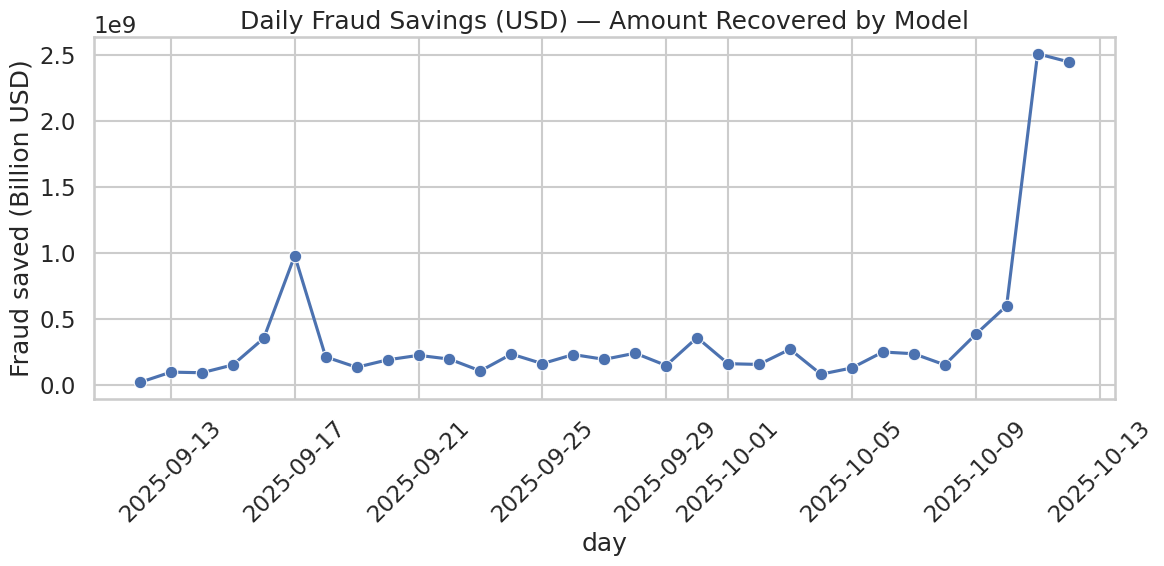

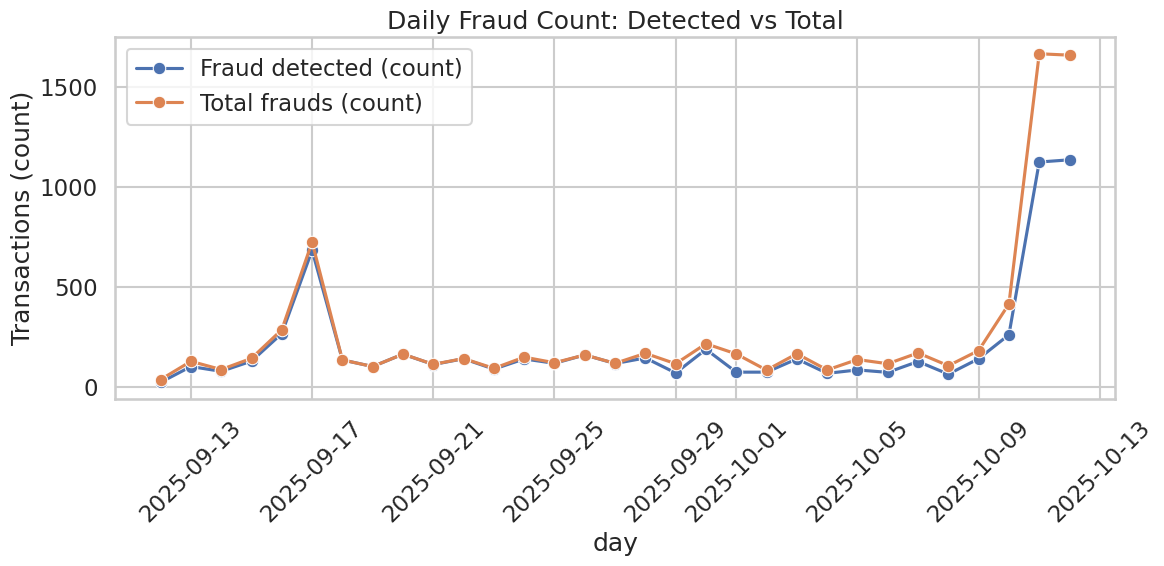

<Figure size 1200x600 with 0 Axes>

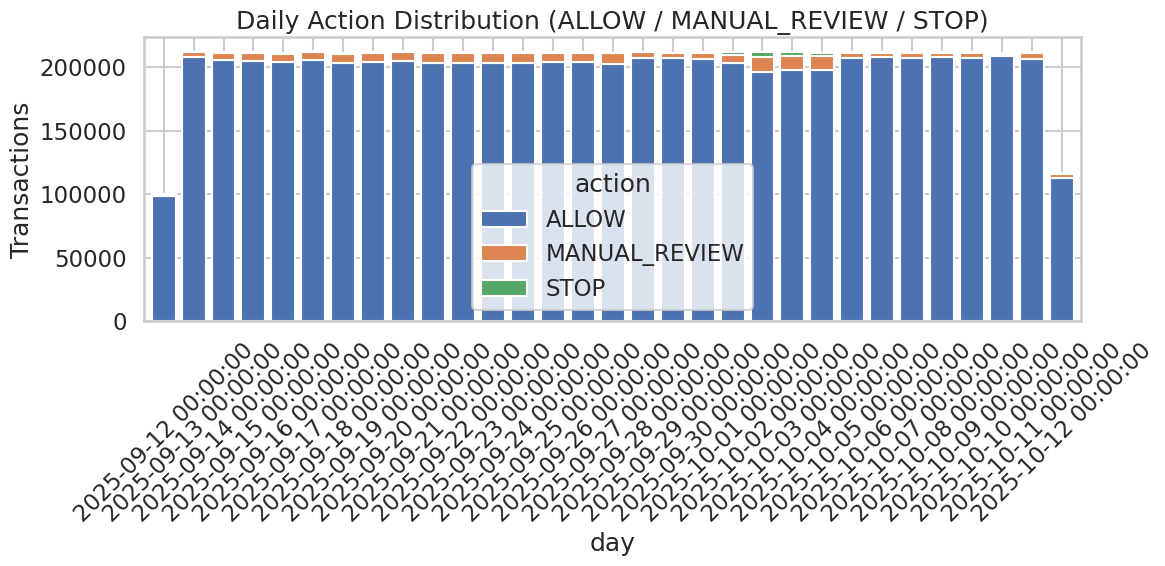

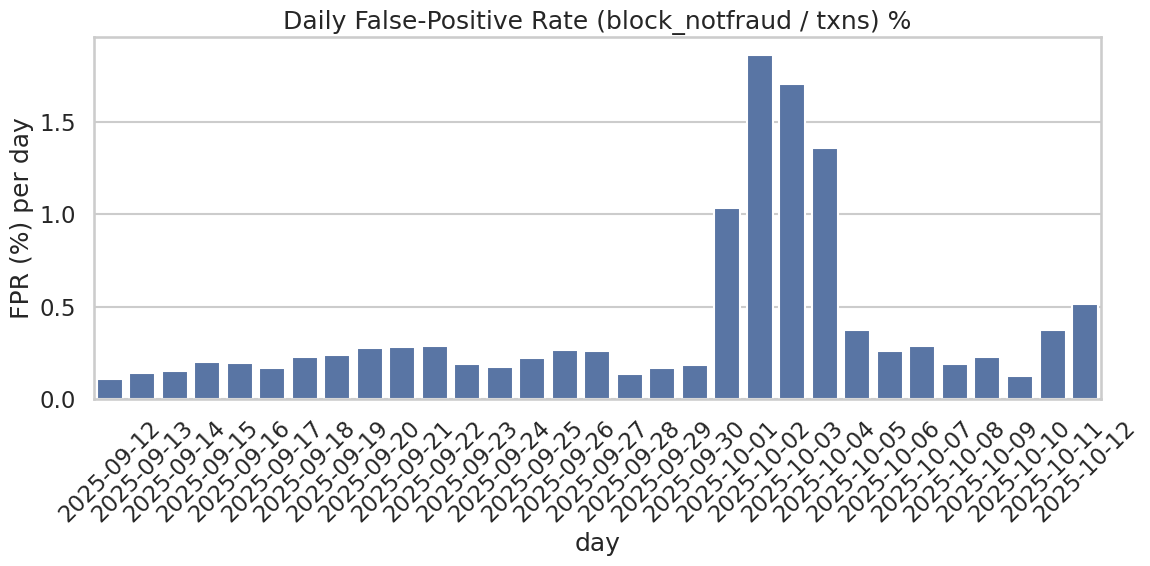

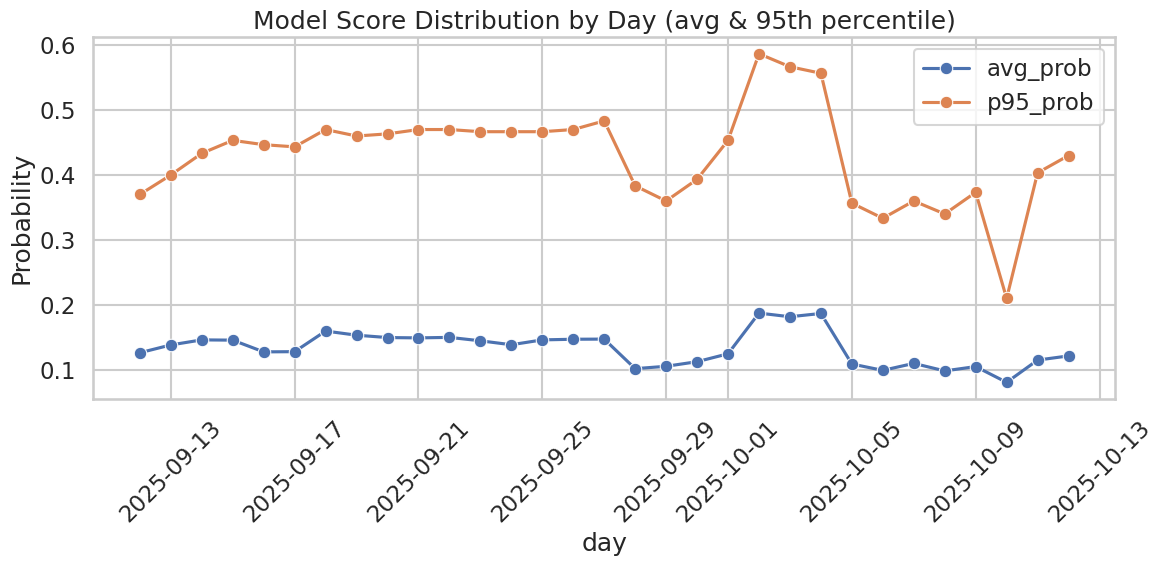

/tmp/ipython-input-3734773504.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipython-input-3734773504.py:97: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(os.path.join(OUT_DIR, "probabilities_cdf.png"))
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


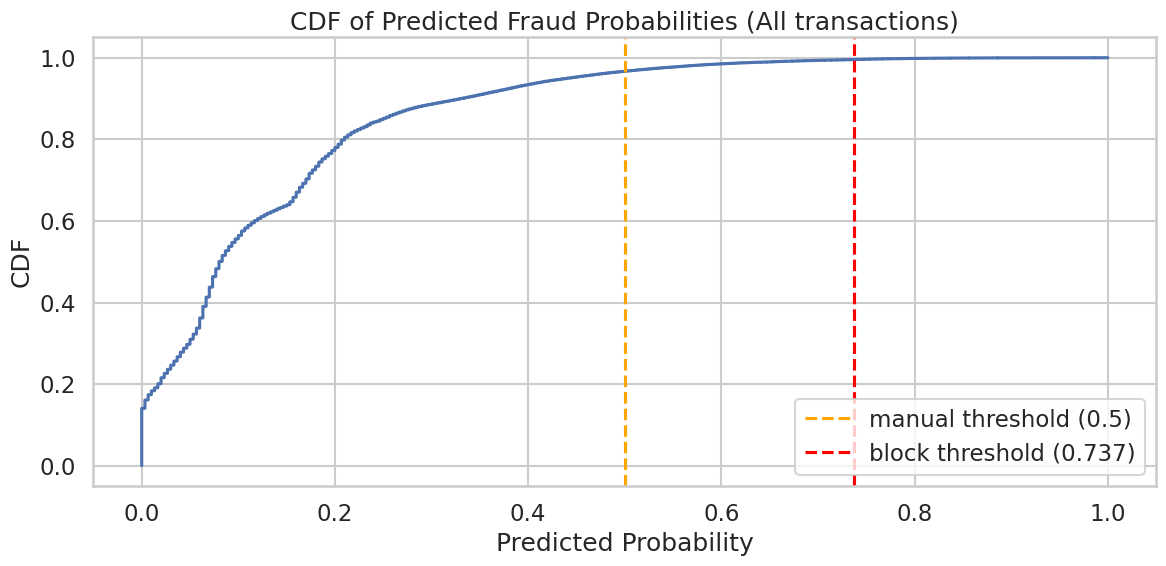

/tmp/ipython-input-3734773504.py:101: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  merged["second"] = merged["timestamp"].dt.floor("S")


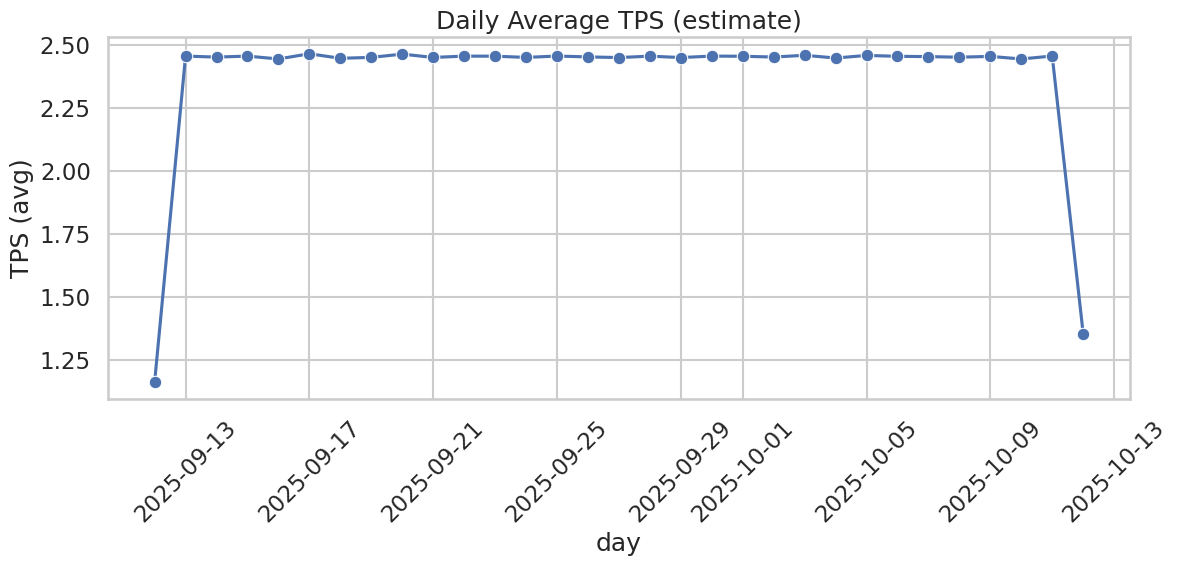

Saved plots to: /content/drive/MyDrive/fraud_detection_checkpoints/plots


In [6]:
# Run this cell in Colab/Jupyter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (12,6)

# === CONFIG: update paths if needed ===
DAILY_PATH = "/content/drive/MyDrive/fraud_detection_checkpoints/matrics/daily_metrics.csv"        # from previous step
MERGED_PATH = "/content/drive/MyDrive/fraud_detection_checkpoints/matrics/merged_sorted_transactions.csv"
OUT_DIR = "/content/drive/MyDrive/fraud_detection_checkpoints/plots"
os.makedirs(OUT_DIR, exist_ok=True)

# === LOAD DATA ===
daily = pd.read_csv(DAILY_PATH, parse_dates=["day"])
merged = pd.read_csv(MERGED_PATH, parse_dates=["timestamp"])

# quick safety
daily = daily.sort_values("day").reset_index(drop=True)

# --- Plot 1: Fraud saved amount per day (USD) ---
plt.figure()
sns.lineplot(data=daily, x="day", y="fraud_saved_amount", marker="o")
plt.title("Daily Fraud Savings (USD) — Amount Recovered by Model")
plt.ylabel("Fraud saved (Billion USD)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "fraud_saved_amount_daily.png"))
plt.show()

# --- Plot 2: Fraud saved count per day vs total frauds per day ---
plt.figure()
ax = plt.gca()
sns.lineplot(data=daily, x="day", y="fraud_saved_count", marker="o", label="Fraud detected (count)", ax=ax)
sns.lineplot(data=daily, x="day", y="frauds", marker="o", label="Total frauds (count)", ax=ax)
ax.set_title("Daily Fraud Count: Detected vs Total")
ax.set_ylabel("Transactions (count)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "fraud_counts_daily.png"))
plt.show()

# --- Plot 3: Action distribution per day (stacked bar) ---
actions_per_day = merged.assign(day=merged["timestamp"].dt.date).groupby(["day","action"]).size().unstack(fill_value=0)
actions_per_day = actions_per_day.reindex(pd.to_datetime(actions_per_day.index)).sort_index()
actions_per_day.index = pd.to_datetime(actions_per_day.index)

plt.figure()
actions_per_day.plot(kind="bar", stacked=True, width=0.8)
plt.title("Daily Action Distribution (ALLOW / MANUAL_REVIEW / STOP)")
plt.ylabel("Transactions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "actions_stacked_daily.png"))
plt.show()

# --- Plot 4: False positives & FPR trend per day ---
daily["block_notfraud_rate_per_day"] = daily["block_notfraud"] / daily["txns"] * 100
plt.figure()
sns.barplot(data=daily, x="day", y="block_notfraud_rate_per_day")
plt.xticks(rotation=45)
plt.title("Daily False-Positive Rate (block_notfraud / txns) %")
plt.ylabel("FPR (%) per day")
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "fpr_daily.png"))
plt.show()

# --- Plot 5: Daily avg probability + P95 probability (confidence trend) ---
plt.figure()
sns.lineplot(data=daily, x="day", y="avg_prob", marker="o", label="avg_prob")
sns.lineplot(data=daily, x="day", y="p95_prob", marker="o", label="p95_prob")
plt.title("Model Score Distribution by Day (avg & 95th percentile)")
plt.ylabel("Probability")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "probability_trend.png"))
plt.show()

# --- Plot 6: CDF of probabilities (overall) with thresholds ---
plt.figure()
probs = merged["probability"].dropna().values
probs_sorted = np.sort(probs)
cdf = np.arange(len(probs_sorted)) / len(probs_sorted)
plt.plot(probs_sorted, cdf)
plt.axvline(0.5, color="orange", linestyle="--", label="manual threshold (0.5)")
plt.axvline(0.737, color="red", linestyle="--", label="block threshold (0.737)")
plt.xlabel("Predicted Probability")
plt.ylabel("CDF")
plt.title("CDF of Predicted Fraud Probabilities (All transactions)")
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "probabilities_cdf.png"))
plt.show()

# --- Plot 7: Daily TPS trend (peak and average) ---
merged["second"] = merged["timestamp"].dt.floor("S")
tps = merged.groupby("second").size().resample("1D").agg(["mean","max"]) if hasattr(merged.groupby("second").size(), 'resample') else None
# fallback calculation for daily TPS: (txns per day) / (86400)
daily["TPS_avg_est"] = daily["txns"] / 86400.0
plt.figure()
sns.lineplot(data=daily, x="day", y="TPS_avg_est", marker="o")
plt.title("Daily Average TPS (estimate)")
plt.ylabel("TPS (avg)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "tps_daily.png"))
plt.show()

# --- Summary output ---
print("Saved plots to:", OUT_DIR)
